## Notebook Overview

In this notebook I've loaded the experimental & synthetic data appropriately, and saved it into csvs.

I removed the parts where I attempted to train LSTM model(s) on this data (and failed to achieve good results), but after I experimented with some more models and achieved some success. For example I had some success using TCN:

https://arxiv.org/abs/1608.08242

*TCNs are usable for shorter sequences as well as longer ones. This approach has been tried in a few papers but it's not as common as other methods (SVR, GPR, I think ARIMA is also explored a lot). I need to actually do a deep-dive into this but haven't had the time so far. Regardless, TCN is a valid approach for time-series data and for this specific problem, having been used in other recent SOH studies.
It's looking like the data has a significant lack of diversity, and there also isn't enough, for a complex model like LSTM to work. Even TCN may be a reach. So, I will proceed with SVR, GPR in my next experiments.*

I might put the code I used for these preliminary experiments, (before finding out SVR was a better fit for this kind of data), into the 'Misc' folder.


# Setup

In [1]:
# required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from glob import glob
import os
import random
# decided to switch from keras to pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

In [2]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# set the working directory
os.chdir('/content/drive/MyDrive/')
print(os.getcwd())

/content/drive/MyDrive


# Data Description

The dataset consists of battery discharge curves - i.e, voltage over time. The voltage ranges from ~4.2 V to 2.5 V, and the maximum time vector is about 72000 points.

There are two separate sets of data - the experimental or 'real' data and the synthetic data.

The experimental data consists of discharge curves from 10 separate cells, which altogether combine to 101 discharge curves. The data can be accessed from .xlsx files but also from .txt files (more simple) where the data is basically arranged as a column of discharge values, with a 1 second interval between values. (Note - if you plan on running P2D.m, use these .txt files).

The synthetic data is the same except there are 1010 samples instead (10 synthetic samples for each real sample) and the data is stored solely as .xlsx files instead of .txt files. The synthetic data generally has each voltage point separated by an interval of 5 seconds, although there is some inconsistency at the very beginning of the discharge curve (an initialisation period of ~50 points). The synthetic data is linearly interpolated to match the sequence lengths of the experimental data.

Each discharge curve corresponds to a State of Health (SOH) label, for which the minimum possible value would be 0 and the maximum possible value would be 1. SOH indicates the health of the battery. In the case of this data it only ranges between 0.91 and 1, which is quite limited and probably why it's been difficult to get a model (at least LSTM) to generalise on this data so far.

DIAG_1 = 100% healthy battery
DIAG_15 = most degraded battery (still only 91% SoH)

SOH values can be extracted from the sorted_labelled_data.xlsx where all the labels are stored (Cell_Name and Diagnostic Test ID columns for the cell and its current diagnostic test, then State of Health for the label. theres some more info in there too like total cycles, capacity, time).

## Data Loading - Experimental Data

In [4]:
# note - don't run the data loading sections again if you've already done it before cause it takes forever just load it from the csvs
sorted_labels_path = os.path.join(os.getcwd(), "MAI-Project/sorted_labelled_data.xlsx")
experimental_data_path = os.path.join(os.getcwd(), "MAI-Project/Experimental Data/")

In [5]:
# look at the data labels
df_labels = pd.read_excel(sorted_labels_path)
df_labels

,Cell_Name,Diagnostic Test ID,State of Health,Cycles Undergone,Capacity,Time
0,G1,1,1.000000,0,4.903099,72780
1,G1,2,0.986736,25,4.838065,71818
2,G1,3,0.973692,30,4.774107,70866
3,G1,4,0.963139,37,4.722365,70099
4,G1,5,0.959786,62,4.705925,69855
...,...,...,...,...,...,...
96,W9,11,0.930321,241,4.534643,67310
97,W9,12,0.926464,266,4.515843,67032
98,W9,13,0.923354,291,4.500686,66807
99,W9,14,0.920435,316,4.486457,66594


In [6]:
# process all of the voltage .txt files and match them with labels
# we're doing experimental data first
def process_txt_file(file_path, diag_id, cell_name, soh_value):
    try:
        # read voltage values (skipping header row)
        voltage_data = np.loadtxt(file_path, skiprows=1)

        # time column (1 second per row)
        time_column = np.arange(1, len(voltage_data) + 1)

        # dataframe
        df = pd.DataFrame({"Time": time_column, "Voltage": voltage_data})
        df["Cell_Name"] = cell_name
        df["Diagnostic Test ID"] = diag_id
        df["State of Health (SOH)"] = soh_value  # Assign SOH label

        return df
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [7]:
# store the processed data
all_data = []

# iterate through the DIAG_ folders
for diag_folder in sorted(os.listdir(experimental_data_path)):
    diag_path = os.path.join(experimental_data_path, diag_folder)

    # if it's a valid DIAG_x folder
    if not os.path.isdir(diag_path) or not diag_folder.startswith("DIAG_"):
        continue

    diag_id = int(diag_folder.split("_")[1])  # extract diagnostic test ID

    # txt_data folder inside
    txt_folder = os.path.join(diag_path, "txt_data")

    if os.path.exists(txt_folder):
        for file in sorted(os.listdir(txt_folder)):
            if not file.endswith(".txt") or file.startswith("."):  # skip hidden/system files
                continue

            file_path = os.path.join(txt_folder, file)

            # extract Cell Name
            file_base = os.path.splitext(file)[0]  # remove .txt extension
            parts = file_base.split("_")

            if len(parts) < 2:
                print(f"Skipping unexpected filename: {file}")
                continue

            cell_name = parts[1]  # extract cell name

            # match SOH value from sorted_labelled_data.xlsx
            matched_soh = df_labels[
                (df_labels["Cell_Name"] == cell_name) &
                (df_labels["Diagnostic Test ID"] == diag_id)
            ]["State of Health"].values

            if len(matched_soh) > 0:
                soh_value = min(matched_soh[0], 1.0)  # ensure SOH ≤ 1
                df = process_txt_file(file_path, diag_id, cell_name, soh_value)
                if df is not None:
                    all_data.append(df)

Skipping unexpected filename: readme.txt
Skipping unexpected filename: readme.txt
Skipping unexpected filename: readme.txt
Skipping unexpected filename: readme.txt
Skipping unexpected filename: readme.txt
Skipping unexpected filename: readme.txt
Skipping unexpected filename: readme.txt
Skipping unexpected filename: readme.txt
Skipping unexpected filename: readme.txt
Skipping unexpected filename: readme.txt
Skipping unexpected filename: readme.txt
Skipping unexpected filename: readme.txt
Skipping unexpected filename: readme.txt
Skipping unexpected filename: readme.txt
Skipping unexpected filename: readme.txt


In [8]:
experimental_data = pd.concat(all_data, ignore_index=True)

In [9]:
experimental_data.columns = ['time', 'voltage', 'cell_name', 'diagnostic_test_ID',
       'state_of_health']

In [10]:
print("Minimum State of Health:", experimental_data.state_of_health.min())
print("Maximum State of Health:", experimental_data.state_of_health.max())

Minimum State of Health: 0.9128203857
Maximum State of Health: 1.0


In [11]:
experimental_data

,time,voltage,cell_name,diagnostic_test_ID,state_of_health
0,1,4.183012,G1,1,1.000000
1,2,4.182744,G1,1,1.000000
2,3,4.182580,G1,1,1.000000
3,4,4.182316,G1,1,1.000000
4,5,4.182269,G1,1,1.000000
...,...,...,...,...,...
6982422,67476,2.501111,W9,9,0.932702
6982423,67477,2.500768,W9,9,0.932702
6982424,67478,2.500363,W9,9,0.932702
6982425,67479,2.500080,W9,9,0.932702


In [12]:
print(experimental_data.cell_name.nunique())
print(experimental_data.cell_name.unique())

10
['G1' 'V4' 'V5' 'W10' 'W3' 'W4' 'W5' 'W7' 'W8' 'W9']


In [13]:
experimental_data = experimental_data.sort_values(by=["cell_name", "diagnostic_test_ID", "time"])
experimental_data

,time,voltage,cell_name,diagnostic_test_ID,state_of_health
0,1,4.183012,G1,1,1.000000
1,2,4.182744,G1,1,1.000000
2,3,4.182580,G1,1,1.000000
3,4,4.182316,G1,1,1.000000
4,5,4.182269,G1,1,1.000000
...,...,...,...,...,...
2599391,66251,2.501635,W9,15,0.915762
2599392,66252,2.501200,W9,15,0.915762
2599393,66253,2.500788,W9,15,0.915762
2599394,66254,2.500462,W9,15,0.915762


In [14]:
unique_tests = experimental_data.groupby('cell_name')['diagnostic_test_ID'].nunique()
mean_health = experimental_data.groupby('cell_name')['state_of_health'].mean()

summary_df = pd.DataFrame({
    'Unique Diagnostic Tests': unique_tests,
    'Mean State of Health': mean_health
})

print(summary_df)
print('Total Diagnostic Tests:', summary_df['Unique Diagnostic Tests'].sum())

           Unique Diagnostic Tests  Mean State of Health
cell_name                                               
G1                              11              0.961764
V4                              11              0.968172
V5                               4              0.986359
W10                             15              0.949146
W3                               3              0.990969
W4                               8              0.968460
W5                              15              0.948512
W7                               4              0.983869
W8                              15              0.945657
W9                              15              0.947901
Total Diagnostic Tests: 101


In [15]:
df_labels.Time.sum()

np.int64(6982527)

In [16]:
cell_name = "W9"
df_W9 = experimental_data[experimental_data["cell_name"] == cell_name]
df_W9

,time,voltage,cell_name,diagnostic_test_ID,state_of_health
649522,1,4.182451,W9,1,1.000000
649523,2,4.182025,W9,1,1.000000
649524,3,4.181830,W9,1,1.000000
649525,4,4.181605,W9,1,1.000000
649526,5,4.181411,W9,1,1.000000
...,...,...,...,...,...
2599391,66251,2.501635,W9,15,0.915762
2599392,66252,2.501200,W9,15,0.915762
2599393,66253,2.500788,W9,15,0.915762
2599394,66254,2.500462,W9,15,0.915762


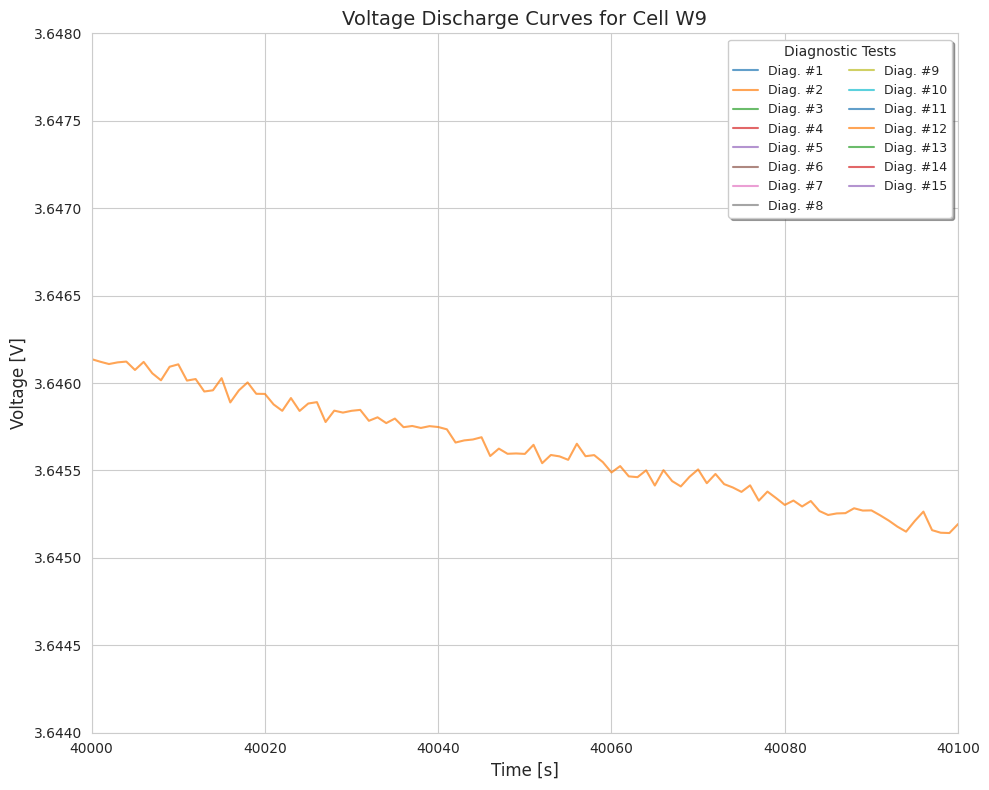

In [17]:
# to visualise W9
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

unique_diagnostics = df_W9["diagnostic_test_ID"].unique()

for diag in unique_diagnostics:
    df_diag = df_W9[df_W9["diagnostic_test_ID"] == diag]
    plt.plot(df_diag["time"], df_diag["voltage"], label=f"Diag. #{diag}", alpha=0.7)

plt.xlabel("Time [s]", fontsize=12)
plt.xlim([40000, 40100])
plt.ylim([3.644, 3.648])
plt.ylabel("Voltage [V]", fontsize=12)
plt.title(f"Voltage Discharge Curves for Cell {cell_name}", fontsize=14)
plt.legend(title="Diagnostic Tests", fontsize=9, loc='upper right',
           fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.show()

In [ ]:
# experimental_data.to_csv("Processed Data/experimental_data_all.csv", index=False) # save the experimental data

## Data Loading - Synthetic Data

In [19]:
sorted_labels_path = os.path.join(os.getcwd(), "MAI-Project/sorted_labelled_data.xlsx")
synthetic_root_dir = os.path.join(os.getcwd(), "MAI-Project/Synthetic Data/")
sorted_soh_df = pd.read_excel(sorted_labels_path)

In [20]:
# preprocess the sorted SOH data for lookup
sorted_soh_df["Cell_Name"] = sorted_soh_df["Cell_Name"].astype(str)
sorted_soh_df["Diagnostic Test ID"] = sorted_soh_df["Diagnostic Test ID"].astype(str)
soh_lookup = {
    (row["Cell_Name"], str(row["Diagnostic Test ID"])): row["State of Health"]
    for _, row in sorted_soh_df.iterrows()
}
# soh_lookup # run this if ya want to see 101 rows of cell + diag + SOH label

In [21]:
# this takes forever so make sure not to run this just load the data via csvs
def load_synthetic_data(root_dir):
    data_list = []

    # diagnostic test folders (DIAG_1, DIAG_2, ...)
    for diag_folder in sorted(os.listdir(root_dir)):
        diag_path = os.path.join(root_dir, diag_folder)
        if not os.path.isdir(diag_path):
            continue  #skip non-directory files

        diag_id = diag_folder.split("_")[1]  # extract diagnostic test number
        print(f"Loading data from Diagnostic Test ID: {diag_id}")

        # cell folders (DiagX_G1_1, DiagX_G1_2, ...)
        for cell_folder in sorted(os.listdir(diag_path)):
            cell_path = os.path.join(diag_path, cell_folder)
            if not os.path.isdir(cell_path):
                continue

            # extract cell name and experiment number
            parts = cell_folder.split("_")
            cell_name = parts[1]  # "G1" from "DiagX_G1_1"
            experiment_no = parts[2]  # "1" from "DiagX_G1_1"
            print(f"  Loading Cell: {cell_name}, Experiment Number: {experiment_no}")

            # ensure the correct SOH value is assigned for all experiments
            soh_value = soh_lookup.get((cell_name, diag_id), None)
            if soh_value is None:
                print(f"    Warning: SOH not found for Cell {cell_name}, Diagnostic Test ID {diag_id}. Skipping...")
                continue  #skip if SOH not found

            # locate the tol0.01_pp1.00.xlsx
            xlsx_path = os.path.join(cell_path, "tol0.01_pp1.00.xlsx")
            if not os.path.exists(xlsx_path):
                print(f"    Warning: File not found: {xlsx_path}. Skipping...")
                continue  #skip if file not found

            # read the file (two columns: time, voltage)
            df = pd.read_excel(xlsx_path, header=None, names=["Time", "Voltage"])

            # filter out negative time values at the initialisation period
            df = df[df["Time"] >= 0]

            # append metadata columns
            df["Cell_Name"] = cell_name
            df["Diagnostic Test ID"] = diag_id
            df["SOH"] = soh_value
            df["Experiment No."] = experiment_no

            # store the processed data
            data_list.append(df)

    return pd.concat(data_list, ignore_index=True) if data_list else pd.DataFrame()

synthetic_df = load_synthetic_data(synthetic_root_dir)

Loading data from Diagnostic Test ID: 1
  Loading Cell: G1, Experiment Number: 1
  Loading Cell: G1, Experiment Number: 10
  Loading Cell: G1, Experiment Number: 2
  Loading Cell: G1, Experiment Number: 3
  Loading Cell: G1, Experiment Number: 4
  Loading Cell: G1, Experiment Number: 5
  Loading Cell: G1, Experiment Number: 6
  Loading Cell: G1, Experiment Number: 7
  Loading Cell: G1, Experiment Number: 8
  Loading Cell: G1, Experiment Number: 9
  Loading Cell: V4, Experiment Number: 1
  Loading Cell: V4, Experiment Number: 10
  Loading Cell: V4, Experiment Number: 2
  Loading Cell: V4, Experiment Number: 3
  Loading Cell: V4, Experiment Number: 4
  Loading Cell: V4, Experiment Number: 5
  Loading Cell: V4, Experiment Number: 6
  Loading Cell: V4, Experiment Number: 7
  Loading Cell: V4, Experiment Number: 8
  Loading Cell: V4, Experiment Number: 9
  Loading Cell: V5, Experiment Number: 1
  Loading Cell: V5, Experiment Number: 10
  Loading Cell: V5, Experiment Number: 2
  Loading Cell

In [22]:
synthetic_df.columns = ['time', 'voltage', 'cell_name', 'diagnostic_test_ID',
       'state_of_health', 'experiment']

In [23]:
synthetic_df.describe()

,time,voltage,state_of_health
count,1.434257e+07,1.434257e+07,1.434257e+07
mean,3.470987e+04,3.647417e+00,9.568502e-01
std,2.028106e+04,3.407296e-01,2.643173e-02
min,3.785908e-05,2.500000e+00,9.128204e-01
25%,1.712597e+04,3.447657e+00,9.338648e-01
50%,3.481947e+04,3.672990e+00,9.535743e-01
75%,5.255329e+04,3.933487e+00,9.800544e-01
max,6.985677e+04,4.134343e+00,1.001177e+00


In [24]:
synthetic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14342573 entries, 0 to 14342572
Data columns (total 6 columns):
 #   Column              Dtype  
---  ------              -----  
 0   time                float64
 1   voltage             float64
 2   cell_name           object 
 3   diagnostic_test_ID  object 
 4   state_of_health     float64
 5   experiment          object 
dtypes: float64(3), object(3)
memory usage: 656.6+ MB


In [25]:
synthetic_df

,time,voltage,cell_name,diagnostic_test_ID,state_of_health,experiment
0,0.014008,4.077552,G1,1,1.000000,1
1,0.045737,4.077550,G1,1,1.000000,1
2,0.132539,4.077544,G1,1,1.000000,1
3,0.219340,4.077538,G1,1,1.000000,1
4,0.306141,4.077532,G1,1,1.000000,1
...,...,...,...,...,...,...
14342568,67639.544757,2.504834,W9,9,0.932702,9
14342569,67644.544757,2.503275,W9,9,0.932702,9
14342570,67649.544757,2.501712,W9,9,0.932702,9
14342571,67654.544757,2.500147,W9,9,0.932702,9


In [26]:
summary_df = synthetic_df.groupby(['cell_name', 'diagnostic_test_ID', 'experiment']).agg(
    Mean_SOH=('state_of_health', 'mean'),  # mean SOH for each cell
).reset_index()

summary_df

,cell_name,diagnostic_test_ID,experiment,Mean_SOH
0,G1,1,1,1.000000
1,G1,1,10,1.000000
2,G1,1,2,1.000000
3,G1,1,3,1.000000
4,G1,1,4,1.000000
...,...,...,...,...
1005,W9,9,5,0.932702
1006,W9,9,6,0.932702
1007,W9,9,7,0.932702
1008,W9,9,8,0.932702


In [27]:
unique_curves = synthetic_df.groupby(['cell_name', 'diagnostic_test_ID', 'experiment']).size().reset_index(name='Count')
number_of_unique_curves = unique_curves.shape[0]
print(f"Total number of unique curves: {number_of_unique_curves}")

Total number of unique curves: 1010


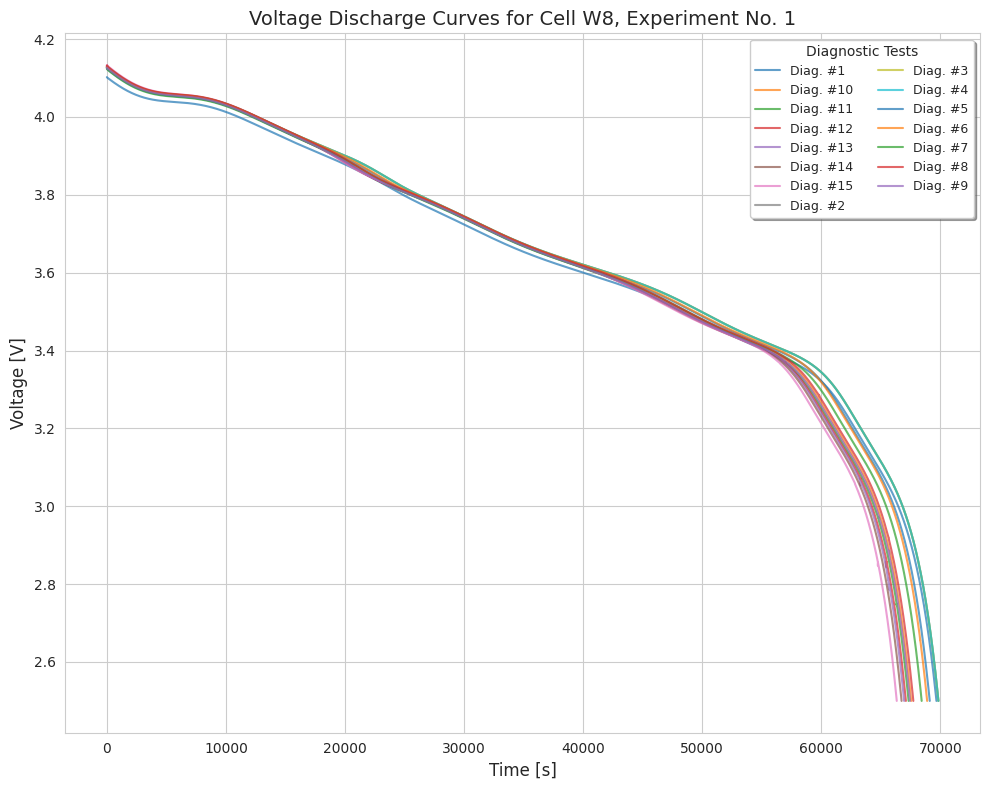

'\nplt.figure(figsize=(10, 8))\nsns.set_style("whitegrid")\n\nunique_diagnostics = filtered_df[\'diagnostic_test_ID\'].unique()\n\nfor diag in unique_diagnostics:\n    df_diag = filtered_df[filtered_df[\'diagnostic_test_ID\'] == diag]\n    plt.plot(df_diag[\'time\'], df_diag[\'voltage\'], label=f"Diag. #{diag}", alpha=0.7)\nplt.xlabel("Time [s]", fontsize=12)\nplt.ylabel("Voltage [V]", fontsize=12)\nplt.title(f"Voltage Discharge Curves for Cell {cell_name}, Experiment No. {experiment_number}", fontsize=14)\nplt.xlim([41500, 42500])\nplt.ylim([3.56, 3.62])\nplt.legend(title="Diagnostic Tests", fontsize=9, loc=\'upper right\', fancybox=True, shadow=True, ncol=2)\n\nplt.tight_layout()\nplt.show()'

In [42]:
cell_name = 'W8'
experiment_number = '1'
filtered_df = synthetic_df[(synthetic_df['cell_name'] == cell_name) & (synthetic_df['experiment'] == experiment_number)]

plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

unique_diagnostics = filtered_df['diagnostic_test_ID'].unique()

# plotting each diagnostic test curve for W9 experiment 3
for diag in unique_diagnostics:
    df_diag = filtered_df[filtered_df['diagnostic_test_ID'] == diag]
    plt.plot(df_diag['time'], df_diag['voltage'], label=f"Diag. #{diag}", alpha=0.7)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Voltage [V]", fontsize=12)
plt.title(f"Voltage Discharge Curves for Cell {cell_name}, Experiment No. {experiment_number}", fontsize=14)

plt.legend(title="Diagnostic Tests", fontsize=9, loc='upper right', fancybox=True, shadow=True, ncol=2)

plt.tight_layout()
plt.show()

# zoomed in.. didnt make a difference rly
"""
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

unique_diagnostics = filtered_df['diagnostic_test_ID'].unique()

for diag in unique_diagnostics:
    df_diag = filtered_df[filtered_df['diagnostic_test_ID'] == diag]
    plt.plot(df_diag['time'], df_diag['voltage'], label=f"Diag. #{diag}", alpha=0.7)
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Voltage [V]", fontsize=12)
plt.title(f"Voltage Discharge Curves for Cell {cell_name}, Experiment No. {experiment_number}", fontsize=14)
plt.xlim([41500, 42500])
plt.ylim([3.56, 3.62])
plt.legend(title="Diagnostic Tests", fontsize=9, loc='upper right', fancybox=True, shadow=True, ncol=2)

plt.tight_layout()
plt.show()"""

In [29]:
synthetic_df = synthetic_df.sort_values(by=["cell_name", "diagnostic_test_ID", "experiment", "time"])

In [30]:
synthetic_df

,time,voltage,cell_name,diagnostic_test_ID,state_of_health,experiment
0,0.014008,4.077552,G1,1,1.000000,1
1,0.045737,4.077550,G1,1,1.000000,1
2,0.132539,4.077544,G1,1,1.000000,1
3,0.219340,4.077538,G1,1,1.000000,1
4,0.306141,4.077532,G1,1,1.000000,1
...,...,...,...,...,...,...
14342568,67639.544757,2.504834,W9,9,0.932702,9
14342569,67644.544757,2.503275,W9,9,0.932702,9
14342570,67649.544757,2.501712,W9,9,0.932702,9
14342571,67654.544757,2.500147,W9,9,0.932702,9


In [31]:
def interpolate_group(group):
    # create a full range from 0 to max time (~72k) at 1-second steps
    new_time = np.arange(0, group["time"].max() + 1, 1)  #from 0 to max time, step=1 sec
    # interpolate voltage at new time points
    interp_df = pd.DataFrame({"time": new_time})
    interp_df["voltage"] = np.interp(new_time, group["time"], group["voltage"])

    interp_df["cell_name"] = group["cell_name"].iloc[0]
    interp_df["diagnostic_test_ID"] = group["diagnostic_test_ID"].iloc[0]
    interp_df["state_of_health"] = group["state_of_health"].iloc[0]
    interp_df["experiment"] = group["experiment"].iloc[0]

    return interp_df

synthetic_df = synthetic_df.groupby(["cell_name", "diagnostic_test_ID", "experiment"]).apply(interpolate_group).reset_index(drop=True)

In [32]:
synthetic_df.head()

,time,voltage,cell_name,diagnostic_test_ID,state_of_health,experiment
0,0.0,4.077552,G1,1,1.0,1
1,1.0,4.077489,G1,1,1.0,1
2,2.0,4.077430,G1,1,1.0,1
3,3.0,4.077380,G1,1,1.0,1
4,4.0,4.077342,G1,1,1.0,1


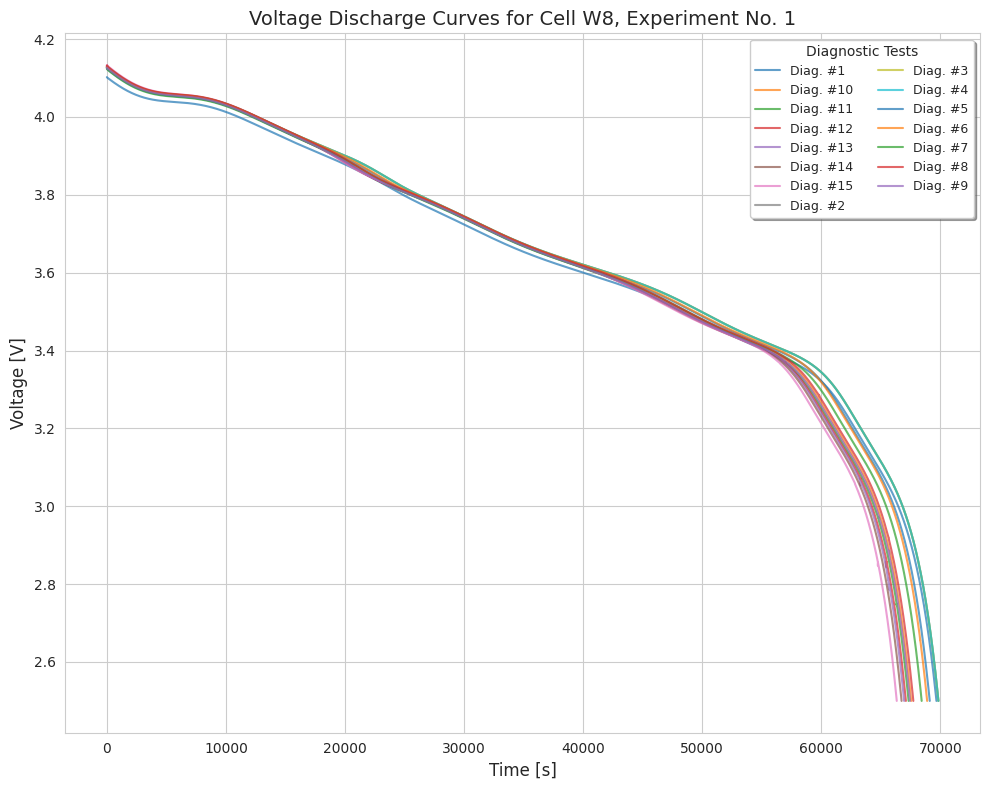

In [35]:
# new plot to see the difference after interpolation - is it different? have a look
cell_name = 'W8'
experiment_number = '1'
filtered_df = synthetic_df[(synthetic_df['cell_name'] == cell_name) & (synthetic_df['experiment'] == experiment_number)]

plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

unique_diagnostics = filtered_df['diagnostic_test_ID'].unique()

# plot each diagnostic test curve
for diag in unique_diagnostics:
    df_diag = filtered_df[filtered_df['diagnostic_test_ID'] == diag]
    plt.plot(df_diag['time'], df_diag['voltage'], label=f"Diag. #{diag}", alpha=0.7)


plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Voltage [V]", fontsize=12)
plt.title(f"Voltage Discharge Curves for Cell {cell_name}, Experiment No. {experiment_number}", fontsize=14)

plt.legend(title="Diagnostic Tests", fontsize=9, loc='upper right', fancybox=True, shadow=True, ncol=2)

plt.tight_layout()
plt.show()


In [ ]:
synthetic_df.to_csv("Processed Data/synthetic_data_all.csv", index=False) # save the processed synthetic data

In [ ]:
# ############   Uncoment if required - Load in Data   ############
experimental_data = pd.read_csv("Processed Data/experimental_data_all.csv")
synthetic_df = pd.read_csv("Processed Data/synthetic_data_all.csv")